# Regression-based Forecasting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

## Main Ideas

Fit linear trend, time as predictor

Modify & use also for non-linear trends
- Exponential
- Polynomial

Also capture seasonality

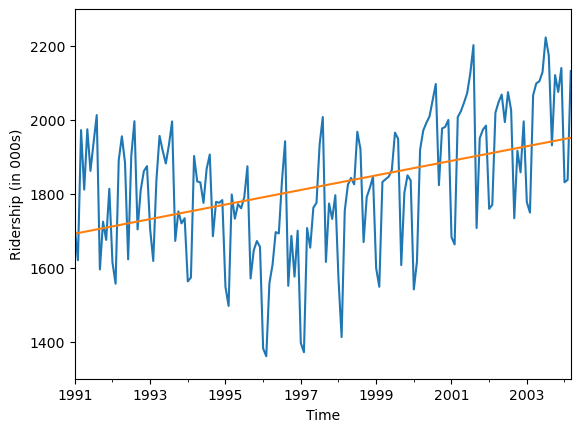

In [3]:
# Load data and convert to time series
Amtrak_df = pd.read_csv('..\\datasets\\Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

# fit a linear trend model to the time series 
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()

# shorter and longer time series
ax = ridership_ts.plot()
ridership_lm.predict(ridership_df).plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
plt.show()

## Regression model

Ridership Y is a function of time (t) and noise (error = e)

Y = B0 + B1*t + e

Thus we model 3 of the 4 components:
- Level (B0)
- Trend (B1)
- Noise (e)

Note that the trend model is linear, which we can see from the graph is not a good fit (more later)

## Apply model to partitioned data 

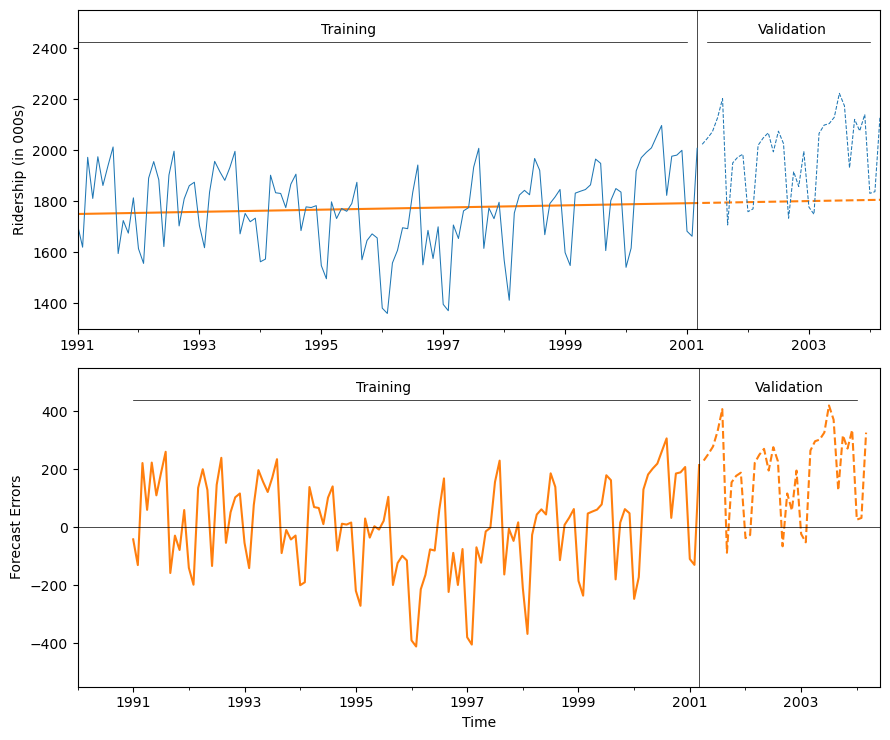

In [4]:
nValid = 36
nTrain = len(ridership_ts) - nValid

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

# Fit linear model using training set and predict on validation set
ridership_lm = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df = ridership_lm.predict(valid_df)

# Create the graph
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_lm.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)

plt.tight_layout()
plt.show()

In [5]:
print(ridership_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Wed, 30 Nov 2022   Prob (F-statistic):              0.390
Time:                        16:12:37   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595     29.073     60.206      0.0

## Exponential Trend

Appropriate model when increase/decrease in series over time is multiplicative 

    e.g. t1 is x% more than t0, t2 is x% more than t1, etc.

Replace Y with log(Y) then fit linear regression

    log(Y) = B0 + B1t + e

Note that performance measures in standard linear regression software are not in original units 

Model forecasts will be in the form log(Y)

Return to original units by taking exponent of model forecasts

Calculate standard deviation of these forecast errors to get RMSE

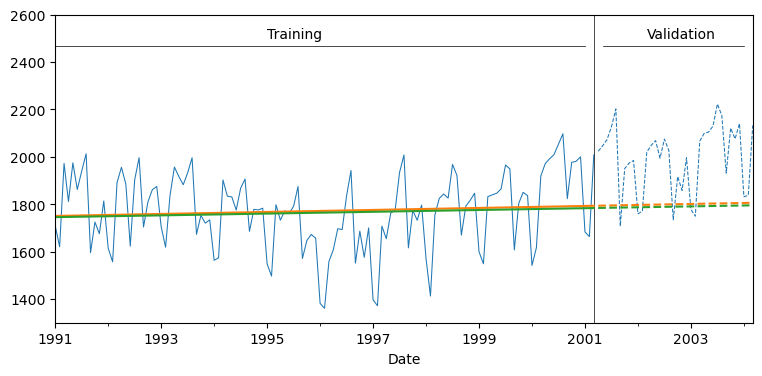

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(Ridership)   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5707
Date:                Wed, 30 Nov 2022   Prob (F-statistic):              0.451
Time:                        16:12:37   Log-Likelihood:                 118.67
No. Observations:                 123   AIC:                            -233.3
Df Residuals:                     121   BIC:                            -227.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4647      0.017    442.535      0.000       7.431       7.498
trend          0.0002      0.000      0.755      0.451      -0.000       0.001
==============================================================================
Omnibus:                        8.566   Durbin-Watson:                   1.106
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.749
Skew:                          -0.652   Prob(JB):                       0.0126
Kurtosis:                       3.091   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
ridership_lm_linear = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df_linear = ridership_lm_linear.predict(valid_df)

ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()
predict_df_expo = ridership_lm_expo.predict(valid_df)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,4))
train_df.plot(y='Ridership', ax=ax, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
singleGraphLayout(ax, [1300, 2600], train_df, valid_df)

ridership_lm_linear.predict(train_df).plot(color='C1')
ridership_lm_linear.predict(valid_df).plot(color='C1', linestyle='dashed')
ridership_lm_expo.predict(train_df).apply(lambda row: math.exp(row)).plot(color='C2')
ridership_lm_expo.predict(valid_df).apply(lambda row: math.exp(row)).plot(color='C2', linestyle='dashed')
ax.get_legend().remove()

plt.show()
ridership_lm_expo.summary()

Exponential trend (green) very similar to linear trend (orange) - neither copes well with initial period of decline followed by growth period

## Polynomial Trend

Add additional predictors as appropriate

For example, for quadratic relationship add a t2 predictor

Fit linear regression using both t and t2


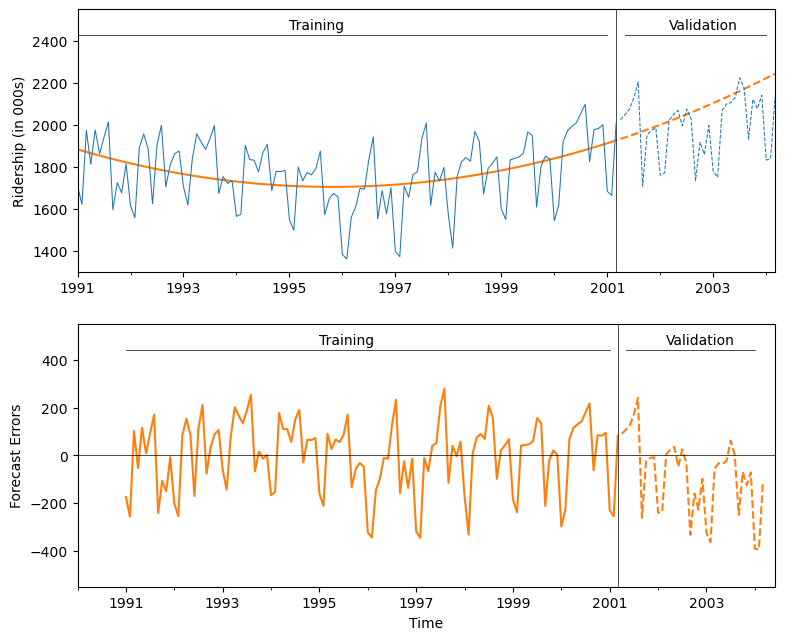

In [7]:
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_poly.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_poly.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_poly.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_poly.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()

Better job capturing the trend, though it over forecasts in validation period.

## Handling Seasonality

Seasonality is any recurring cyclical pattern of consistently higher or lower values (daily, weekly, monthly, quarterly, etc.)

Handle in regression by adding categorical variable for season, e.g. 11 dummies for month (using all 12 would produce multicollinearity error)


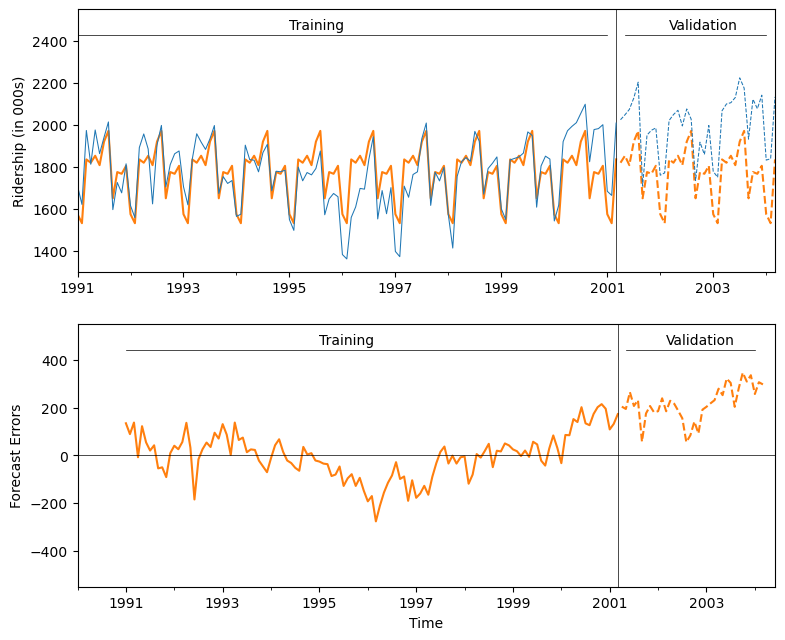

In [8]:
ridership_df = tsatools.add_trend(ridership_ts, trend='c')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_season.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_season.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_season.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()

In [9]:
print(ridership_lm_season.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     17.54
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           1.20e-19
Time:                        16:12:38   Log-Likelihood:                -736.38
No. Observations:                 123   AIC:                             1497.
Df Residuals:                     111   BIC:                             1531.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1573.9722     30.578     51.

## Final model, Amtrak data

Incorporates quadratic trend and seasonality

13 predictors: 

    11 monthly dummies
    t
    t2

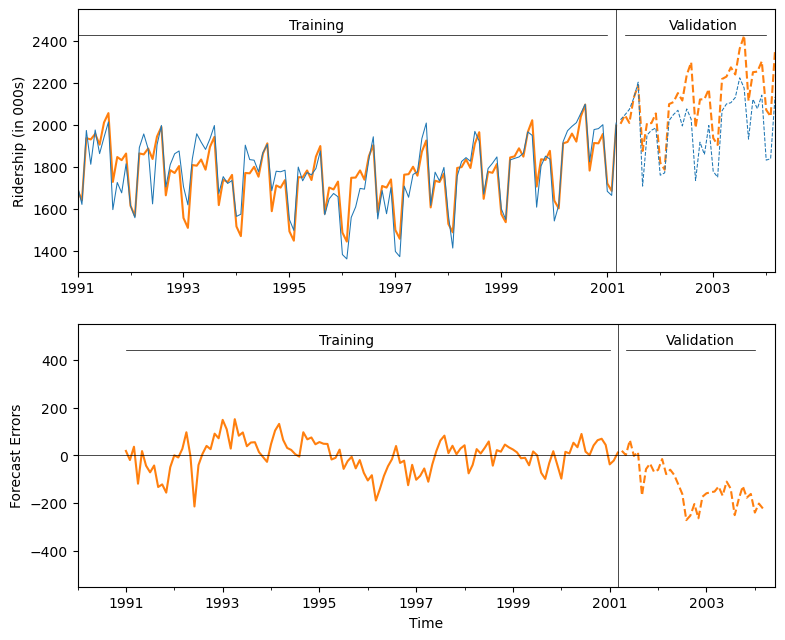

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           3.75e-35
Time:                        16:12:38   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1696.9794     27.675  

In [10]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_trendseason = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_trendseason.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_trendseason.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()
print(ridership_lm_trendseason.summary())

This model is better, though it still over-estimates in the validation period.

If we are happy with the structure of this model, we can re-fit it to the entire dataset and use it to generate look-ahead forecasts.

## Autocorrelation

Unlike cross-sectional data, time-series values are typically correlated with nearby values (“autocorrelation”)

Ordinary regression does not account for this


## Computing autocorrelation

Create “lagged” series 

Copy of the original series, offset by one or more timer periods

Compute correlation between original series and lagged series -> lag-1, lag-2, etc.


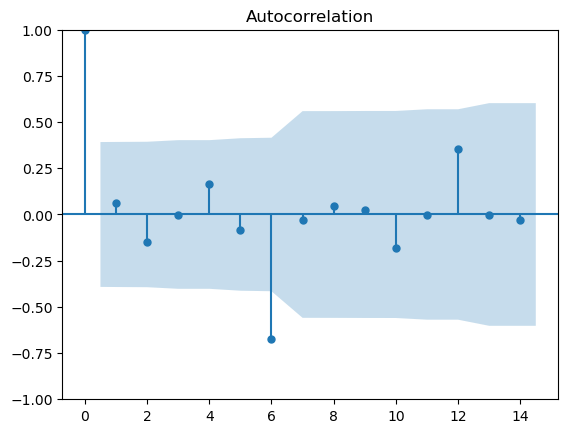

[ 1.          0.06354378 -0.14949875 -0.00302953  0.16599849 -0.08598409
 -0.67557862 -0.02827413  0.04544556  0.02448555 -0.18279117 -0.00400188
  0.35545531 -0.00433123]


In [11]:
tsaplots.plot_acf(train_df['1991-01-01':'1993-01-01'].Ridership)
plt.show()
print(stattools.acf(train_df['1991-01-01':'1993-01-01'].Ridership))

Positive autocorrelation at lag-1 = stickiness

Strong autocorrelation (positive or negative) at a lag > 1 indicates seasonal (cyclical) pattern

Autocorrelation in residuals at the season lag disappears once the model incorporates seasonality

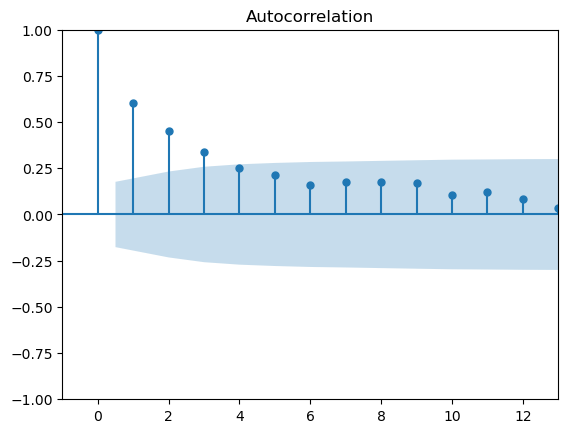

[ 1.          0.60405883  0.44983171  0.3373083   0.25329034  0.21565844
  0.15901326  0.17676683  0.17553762  0.17140882  0.10739472  0.11976519
  0.08512942  0.03621337 -0.04100296 -0.10220097 -0.08359282 -0.10871958
 -0.13125876 -0.19609773 -0.18755508]


In [12]:
residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df)
tsaplots.plot_acf(residual)
plt.xlim(-1, 13)
plt.show()
print(stattools.acf(residual))

## Incorporating Autocorrelation into Models

Use a forecasting method to forecast k-steps ahead

Fit AR (autoregressive) model to residuals

Incorporate residual forecasts

Improved Ft+k = Ft+k + Et+k

## Choose order of the AR model

If autocorrelation exists at Lag-1, a Lag-1 model should be sufficient to capture lags at other periods as well

Et = B0 + B1Et-1 + e

Where Et is residual (forecast error) at time t

In [13]:
formula = 'Ridership ~ trend + np.square(trend) + C(Month)'
train_lm_trendseason = sm.ols(formula=formula, data=train_df).fit()
train_res_arima = ARIMA(train_lm_trendseason.resid, order=(1, 0, 0), freq='MS').fit()

print(train_res_arima.summary())
print(pd.DataFrame({'coef': train_res_arima.params, 'std err': train_res_arima.bse}))

forecast = train_res_arima.forecast(1)
print(forecast)
print(train_lm_trendseason.resid[-1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  123
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -663.542
Date:                Wed, 30 Nov 2022   AIC                           1333.084
Time:                        16:12:38   BIC                           1341.521
Sample:                    01-01-1991   HQIC                          1336.511
                         - 03-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328     13.039      0.003      0.998     -25.522      25.588
ar.L1          0.5998      0.076      7.901      0.000       0.451       0.749
sigma2      2828.8236    291.611      9.701      0.0

C:\Users\anamini\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
print(ridership_lm_trendseason.predict(valid_df).head(), valid_df.head())

Date
2001-04-01    2004.270893
2001-05-01    2045.419400
2001-06-01    2008.675207
2001-07-01    2128.560114
2001-08-01    2187.911321
dtype: float64             Ridership  const  trend  Month
Date                                      
2001-04-01   2023.792    1.0  124.0      4
2001-05-01   2047.008    1.0  125.0      5
2001-06-01   2072.913    1.0  126.0      6
2001-07-01   2126.717    1.0  127.0      7
2001-08-01   2202.638    1.0  128.0      8


               coef     std err
ar.L1     -0.105768    0.244722
ar.L2     -0.047047    0.068428
ar.L3     -0.959666    0.065102
ar.L4     -0.082160    0.226458
ar.L5     -0.009311    0.059197
ar.L6     -0.881851    0.057799
ar.L7     -0.084839    0.227591
ar.L8     -0.005618    0.055882
ar.L9     -0.878526    0.046863
ar.L10    -0.077133    0.203868
ma.L1     -0.354498    0.273390
ma.L2     -0.026175    0.173224
ma.L3      0.741852    0.130944
ma.L4     -0.373358    0.172394
sigma2  4484.872191  578.100073
Forecast {forecast}:.3f}]


C:\Users\anamini\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


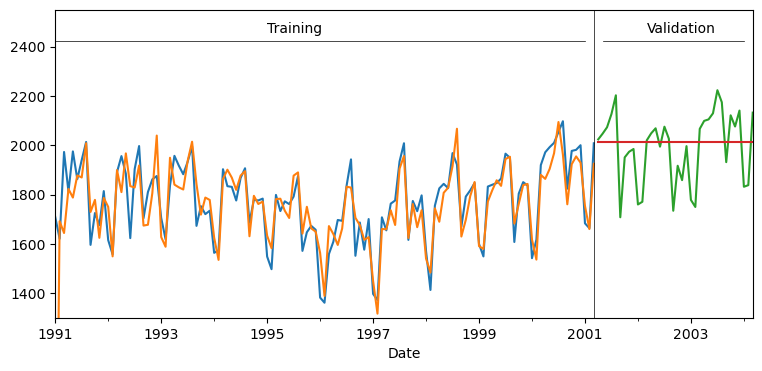

In [15]:
train_ridership_arima = ARIMA(train_df.Ridership, order=(10, 1, 4), freq='MS').fit()
forecast = train_ridership_arima.forecast(1)
print(pd.DataFrame({'coef': train_ridership_arima.params, 'std err': train_ridership_arima.bse}))
print('Forecast {forecast}:.3f}]')

ax = train_df.Ridership.plot(figsize=(9,4))
train_ridership_arima.fittedvalues.plot(ax=ax)
singleGraphLayout(ax, [1300, 2550], train_df, valid_df)
valid_df.Ridership.plot(ax=ax)

forecast = pd.Series(train_ridership_arima.forecast(len(valid_df))[0], index=valid_df.index)
forecast.plot(ax=ax)
plt.show()

## Autocorrelation of Residuals

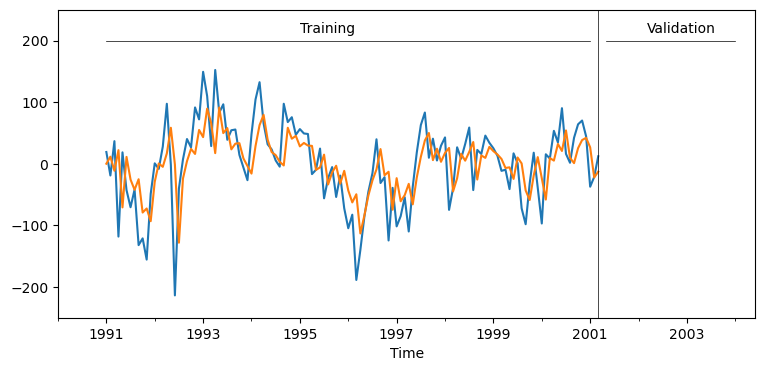

In [16]:
ax = train_lm_trendseason.resid.plot(figsize=(9,4))
train_res_arima.fittedvalues.plot(ax=ax)
singleGraphLayout(ax, [-250, 250], train_df, valid_df)
plt.show()

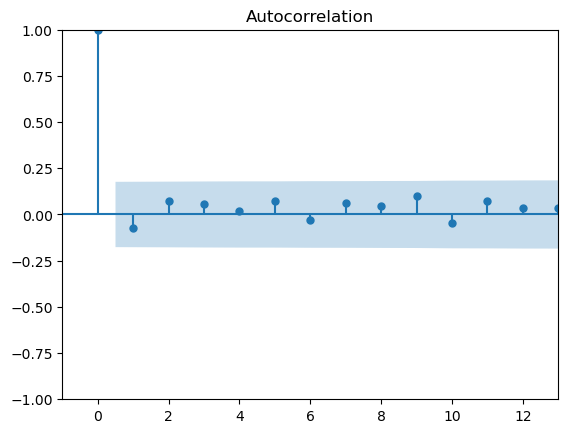

In [17]:
tsaplots.plot_acf(train_res_arima.resid)
plt.xlim(-1, 13)
plt.show()

## Summary – Regression Based Forecasting

Can use linear regression for exponential models (use logs) and polynomials (exponentiation)

For seasonality, use categorical variable (make dummies)

Incorporate autocorrelation by modeling it, then using those error forecasts in the main model
